# Tutorial 1: Simple Calcium

The system of calcium's ground state excited to its first excited state with an on-resonance laser is one of the simplest systems to model as there is only a ground S-state and an excited P-state with no hyperfine structure. We can verify results already published by [Murray 2003](https://iopscience.iop.org/article/10.1088/0953-4075/36/24/011/meta) by using the `LASED` package. In this paper the transition between the ground S-state and the first excited singlet P-state is modelled with the laser on-resonance and 200 MHz & 500 MHz detuned from resonance.

First, we'll set up the states. A diagram of the system we are going to model is seen below. The ground S-state is represented by one sub-state lebelled as $|1\rangle$ and the excited P-state is represented by three sub-states labelled as $|2\rangle$, $|3\rangle$, and $|4\rangle$. 

The numbers indicate the labelling I have given them. It is convention to label the sub-states in your system by labelling the lowest in energy state first. The sub-state with the lowest $m$ value is labelled as $|1\rangle$ and then the 2nd lowest $m$ value as $|2\rangle$ etc. until you run out of sub-states. Then, the next highest in energy state is labelled.

The wavelength of the difference in energy between these two states is also shown as 422.8 nm. 

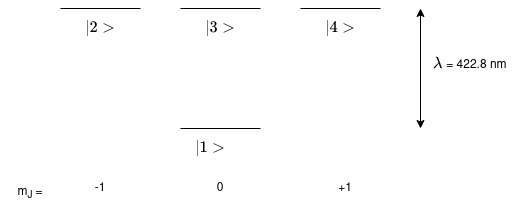

In [1]:
from IPython.display import Image
Image(filename = "../../../LevelDiagrams/Calcium.jpg")

Now, we'll import the `LASED` library and a plotting library. I use `Plotly` to plot all the figures here but any plotting library can be used.

In [2]:
import LASED as las

import plotly.graph_objects as go  # For plotting
import plotly.offline as plo  # To render offline plots for exporting this notebook to html
import time  # For seeing how quickly the time evolution is calculated
import numpy as np

plo.init_notebook_mode(connected=True)  # IGNORE: For plotly rendering offline images

## Setting up the System

With LASED you can declare atomic sub-states using the `State` object. These states are used to declare a `LaserAtomSystem` which can then be used to calculate the time evolution of the system.

First, we must declare the system's variables: wavelength of the transition, lifetime of the excited state, isospin, etc. 

**Note**: LASED has a timescale of nanoseconds so all times will be input in nanoseconds. If I want a lifetime of 4.6e-9 s then I have to input 4.6 into my `LaserAtomSystem` object.

In [3]:
wavelength_ca = 422.8e-9  # wavelength of Ca transition in metres
tau_ca = 4.6 # lifetime in nanoseconds
I_ca = 0  # Isospin of calcium

Create the `State` objects by providing the `label` of the sub-state with the convention as above. **The system may not be modelled correctly if you do not stick to this labelling convention**.

Each sub-state must have a relative angular frequency `w` associated with it. This angular frequency is related to the energy as usual $E = \hbar w$. All frequencies should be in gigaradians per second. The energies are _relative_ so you just have to set a zero point and then all other sub-states have energies relative to this point. I have set the zero-point as the energy of the ground sub-state.

Each sub-state must be labelled with its corresponding quantum numbers: orbital angular momentum `L`, spin `S`, projection of total angular momentum `m`. The isospin `I` is assumed to be zero if not specified. The total angular momentum (without isospin) can be specified with keyword `J` and is calculated as `J=L+S` if not specified. The total angular momentum with isospin can be specified with keyword `F` and if not specifed is calculated as `F=J+I`.

To create the ground or excited state you must insert each sub-state in an ordered list starting with the smallest labelled state to the highest labelled state. 

In [4]:
# Calculate angular frequency of the transition
w_e = las.angularFreq(wavelength_ca)  # Converted to angular frequency in Grad/s

# Create states
s1 = las.State(label = 1, w = 0, m = 0, L = 0, S = 0)
s2 = las.State(label = 2, w = w_e, m = -1, L = 1, S = 0)
s3 = las.State(label = 3, w = w_e, m = 0, L = 1, S = 0)
s4 = las.State(label = 4, w = w_e, m = 1, L = 1, S = 0)
print(s3)

# Create ground and excited states list
G_ca = [s1]
E_ca = [s2, s3, s4]

State(label = 3, w = 4455183.460995396, m = 0, L = 1, J = 1, I = 0, F = 1)


Declare the laser parameters. The intensity of the laser `laser_intensity` must be in u nits of mW/mm$^2$. 

The polarisation of the laser is defined by keyword `Q` and is either right-hand circular ($\sigma^+$) with a +1, left-hand circular ($\sigma^-$) with a -1, and linear ($\pi$) polarisation with the polarisation axis defined along the axis with a 0 (angle of polarisation of zero degrees). `Q` is defined as a list of any of these three values. 

The `detuning` of the laser away from resonance can be specified as well. If no detuning is given then the laser is assumed to be on-resonance i.e. `detuning = 0`

**Note on using more than one polarisation**: If more than one value is in the list then the laser is defined as having simulataneous polarisations of the same laser acting upon the atom. This can be possible if working in the natural frame when the laser is travelling along the direction of the quantisation axis and the polarisation is linear in the collision frame. When working in this natural frame `Q = [-1, 1]`. You must normalise the Rabi frequencies if you do this by a normalisation constant by giving the `LaserAtomSystem` an attribute called `rabi_scaling`. In this case of two simultaneous Rabi frequencies, the correct time evolution would be scaled by `1/np.sqrt(2)`. If `n` simultaneous polarisations are used then it must be scaled by `1/np.sqrt(n)`. You must also apply the `rabi_factors` attribute as the simultaneous combination of LHC and RHC Rabi frequencies is only equal to a linear exciation if the total Rabi frequency is $1/\sqrt(2)(\Omega^{-1}-\Omega^{+1})$ so the RHC Rabi frequency must be multiplied by -1. This is achieved by setting the `rabi_factors` attribute to `rabi_factors = [1, -1]` if using a `Q` as stated above. Each element of `Q` is multiplied by the corresponding element in `rabi_factors`.

In [5]:
intensity_ca = 100 # mW/mm^-2
Q_ca = [0]
detuning = 0.2*2*np.pi  # detuning here is 200 MHz in Grad/s
detuning2 = 0.5*2*np.pi  # detuning here is 500 MHz in Grad/s

The `time` over which the simulation run must be sepcified. It must be specified with a list with every discrete time step (in nanoseconds) in it. Numpy's `linspace` is handy for this task.

In [6]:
# Simulation parameters
start_time = 0
stop_time = 50 # in ns
time_steps = 501
time_ca = np.linspace(start_time, stop_time, time_steps)

Create a `LaserAtomSystem` object by using the variables stated above. Three system's are created here for different detunings. 

In [7]:
calcium_system = las.LaserAtomSystem(E_ca, G_ca, tau_ca, Q_ca, wavelength_ca, 
                                 laser_intensity = intensity_ca)

calcium_system200MHzdetuned = las.LaserAtomSystem(E_ca, G_ca, tau_ca, Q_ca, wavelength_ca, 
                                 laser_intensity = intensity_ca)
calcium_system500MHzdetuned = las.LaserAtomSystem(E_ca, G_ca, tau_ca, Q_ca, wavelength_ca, 
                                 laser_intensity = intensity_ca)

## Time Evolution of the System

Perform a `timeEvolution` of each system. The `pretty_print_eq` keyword is used here to print out the system's equations of motion using `Sympy`. There are many other keywords which can be used with `timeEvolution` including averaging over the doppler profile of the atoms, averaging the Gaussian laser beam profile, and numerically printing the equations.

I have just timed this piece of code to see how long it takes.

**Note**: And initial density matrix can be specified at t = 0 to evolve. If none is stated then all ground sub-states are populated equally with no coherence between sub-states.

In [8]:
tic = time.perf_counter()
calcium_system.timeEvolution(time_ca,
                             pretty_print_eq = True)
calcium_system200MHzdetuned.timeEvolution(time_ca,
                             detuning = detuning)
calcium_system500MHzdetuned.timeEvolution(time_ca,
                             detuning = detuning2)
toc = time.perf_counter()
print(f"The code finished in {toc-tic:0.4f} seconds")

Populating ground states equally as the initial condition.


Populating ground states equally as the initial condition.
Populating ground states equally as the initial condition.
The code finished in 7.6810 seconds


## Saving and Plotting

We can save the data to a .csv file and now plot the data generated to see the time evolution.

To save to csv use the `saveToCSV("filename")` function on your `LaserAtomSystem` object. 

In [9]:
calcium_system.saveToCSV("SavedData/SimpleCalciumNoDetuning.csv")
calcium_system200MHzdetuned.saveToCSV("SavedData/SimpleCalcium200MHzDetuning.csv")
calcium_system500MHzdetuned.saveToCSV("SavedData/SimpleCalcium200MHzDetuning.csv")

Now, we can plot the evolution of Calcium with no detuning, 200 MHz detuning, and 500 MHz detuning.

To access the density matrix elements over the time evolution use the function `Rho_t(e, g)` on the `LaserAtomSystem`. This gives a list of the element $\rho_{eg}$ for each interval in `time`. Each element of the density matrix is `complex` so the real part is taken by using the `abs()` function. 

In [13]:
rho_33 = [abs(rho) for rho in calcium_system.Rho_t(s3, s3)]
rho_33_200MHzdetuned = [abs(rho) for rho in calcium_system200MHzdetuned.Rho_t(s3, s3)]
rho_33_500MHzdetuned = [abs(rho) for rho in calcium_system500MHzdetuned.Rho_t(s3, s3)]

fig_ca = go.Figure()
fig_ca.add_trace(go.Scatter(x = time_ca,
                                 y = rho_33,
                                 mode = 'lines',
                                    name = "Rho_33 (δ = 0 MHz)",
                                    marker = dict(
                                color = 'red',
                                symbol = 'circle',
                            )))
fig_ca.add_trace(go.Scatter(x = time_ca,
                                 y = rho_33_200MHzdetuned,
                                 mode = 'lines',
                                    name = "Rho_33 (δ = 200 MHz)",
                                    marker = dict(
                                color = 'blue',
                                symbol = 'circle',
                            )))
fig_ca.add_trace(go.Scatter(x = time_ca,
                                 y = rho_33_500MHzdetuned,
                                 mode = 'lines',
                                    name = "Rho_33 (δ = 500 MHz)",
                                    marker = dict(
                                color = 'green',
                                symbol = 'circle',
                            )))

fig_ca.update_layout(title = "Calcium: Time Evolution of Upper State Population with Linear Excitation: I = 100 mW",
                 xaxis_title = "Time (ns)",
                 yaxis_title = "Population",
                font = dict(
                    size = 11))

go.FigureWidget(fig_ca)

FigureWidget({
    'data': [{'marker': {'color': 'red', 'symbol': 'circle'},
              'mode': 'lines',
  …